In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import scipy
from scipy import signal
import math
import pandas as pd
from datetime import datetime
import timeit

In [4]:
# Helper function to generating a Waveforms
## DCT & invDCT

def synthesizeWave(amp,freq,dur = 1,frate = 10000):
    dt = 1/frate
    ts = np.arange(0, dur+dt, dt)
    ts_mat   = np.outer(ts,freq)
    wave_mat = np.cos(2*np.pi * ts_mat)
    wave = np.dot(wave_mat,amp)
    return wave,ts

def analyze(wave,ts,freq):
    N       = len(wave)
    ts_mat  = np.outer(ts,freq)
    wave_mat = np.cos(2*np.pi * ts_mat)
    amps = np.linalg.solve(wave_mat, wave)
    return amps  

def test1():
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    N = 4.0
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    ts_mat   = np.outer(ts,fs)
    wave_mat = np.cos(2*np.pi * ts_mat)
    return wave_mat

def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M    = np.cos(np.pi * 2 * args)
    ys = np.dot(M, amps)
    return ys

def compressAudioFile(dctspec,thresh = 10):
    count = 0
    for i in range(len(dctspec)):
        if abs(dctspec[i]) < thresh:
            dctspec[i] = 0
            count += 1
    return dctspec,100*count/len(dctspec)
            
    
# Not sure what the purpose of this is
# (only works with synthesized wave that fits specific ts and fs)
def dct_iv(ys):
    N  = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(np.pi * 2 * args)
    amps = np.dot(M, ys) / 2
    return amps

def inverse_dct_iv(amps):
    return dct_iv(amps) * 2

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein):
    n = len(datain)
    # power spectral density
    hsout = np.fft.rfft(datain)
    # frequency spectrum
    freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_wave(hsin):
    wave = np.fft.irfft(hsin)
    return wave

def GenerateUncorrelatedNoise(amp=1,dur=1,frate=10000):
    ts = np.arange(0,dur+1/frate,1/frate)
    result = np.random.uniform(-amp, amp, len(ts))
    return result,ts

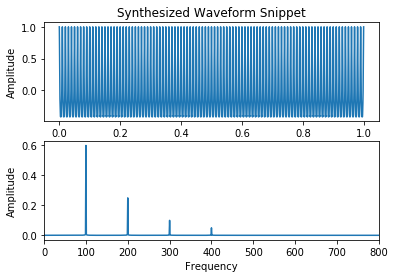

In [6]:
# Synthesize a wave consisting of multiple sub-waves
amps   = np.array([0.6,0.25,0.1,0.05])
freqs  = np.array([100,200,300,400])
wave,ts1 = synthesizeWave(amp = amps,freq = freqs,dur = 1,frate = 10000)

spec,fq = make_spectrum(wave,10000)
plt.subplot(211)
plt.plot(ts1,wave)
plt.title('Synthesized Waveform Snippet')
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.subplot(212)
maxAmp = np.amax(np.abs(spec))
plt.plot(fq,(np.abs(spec)*.6)/maxAmp)
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.xlim([0,800])
plt.show()

In [90]:
# Analyze to find Amplitudes of frequencies components in Signal
# Use a linear solver to deduce the amplitude of isolated waveforms for frequency inputs
n = len(freqs)
ampCompute = analyze(wave[:n],ts1[:n],freqs)
print(ampCompute)

[ 0.6   0.25  0.1   0.05]


In [86]:
M = test1()
print("New Synthesized Waveform now symmetric and orthoganol --> ",np.allclose(M, M.T, atol=1e-8))
print(np.dot(M.T,M)/ 2)

New Synthesized Waveform now symmetric and orthoganol -->  True
[[  1.00000000e+00   0.00000000e+00   8.32667268e-17   1.11022302e-16]
 [  0.00000000e+00   1.00000000e+00  -5.55111512e-17  -1.11022302e-16]
 [  8.32667268e-17  -5.55111512e-17   1.00000000e+00  -2.77555756e-16]
 [  1.11022302e-16  -1.11022302e-16  -2.77555756e-16   1.00000000e+00]]


[ 0.125  0.375  0.625  0.875] [ 0.25  0.75  1.25  1.75]
[ 0.6   0.25  0.1   0.05]


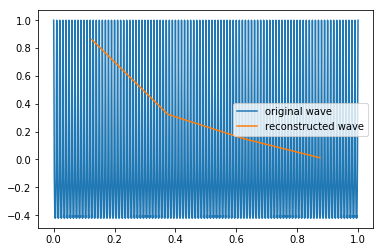

Not sure what the point of this is??


In [9]:
# Since the wave_mat is symmetric and orthonormal, we can use an optimized method of determining freq amplitudes
# Using DCT [type 4]
amps = np.array([0.6, 0.25, 0.1, 0.05])
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2
print(ts,fs)
wave2 = synthesize2(amps, fs, ts)
amps2 = dct_iv(wave2)
# Now reconstruct the original wave
wave_new = inverse_dct_iv(amps2)
plt.plot(ts1,wave)
plt.plot(ts,wave_new)
plt.legend(['original wave','reconstructed wave'])
plt.show()
print("Not sure what the point of this is??")

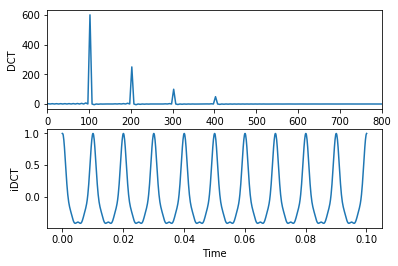

In [106]:
# Converting from Freq to time domain via DCT using scipy
# DCT
N = len(wave)
frate = 10000
swave = scipy.fftpack.dct(wave,type=2)
fs = (0.5 + np.arange(N)) / 2
# iDCT
ys = scipy.fftpack.idct(swave, type=2) / 2 / N
ts = np.full([1,len(ys)],1/frate)
ts = np.cumsum(ts)
ts[0] = 0

# visualize
plt.subplot(211)
plt.plot(fs*10,swave)
plt.xlim([0,800])
plt.xlabel('Frequency')
plt.ylabel('DCT')

plt.subplot(212)
plt.plot(ts,ys)
plt.xlabel('Time')
plt.ylabel('iDCT')
plt.show()

In [129]:
# Compare Performance of different Methods: DCT (ii,iv), linear solver, and FFT
dctresults    = []
linresults   = []
fftresults    = []
ns = 2 ** np.arange(6, 13)
nwave,ts = GenerateUncorrelatedNoise(dur = 3)
freqs    = np.arange(2**13)
print('NOTE: DCT deals with only real numbers, where FCT deals with complex numbers')
for N in ns:
    print("***     Frequency Components: ",N)
    print("  Scipy DCT_type2 performance: ")
    dctresult = %timeit -r1 -o scipy.fftpack.dct(nwave,type=2)
    print("  DCT Linear Solver performance: ")
    lsolveresult = %timeit -r1 -o analyze(nwave[:N],ts[:N],freqs[:N])
    print("  Scipy FFT performance: ")
    fftresult = %timeit -r1 -o scipy.fftpack.fft(nwave)
    print()
    # Save results
    dctresults.append(dctresult)
    linresults.append(lsolveresult)
    fftresults.append(fftresult)

NOTE: DCT deals with only real numbers, where FCT deals with complex numbers
***     Frequency Components:  64
  Scipy DCT_type2 performance: 
18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
  DCT Linear Solver performance: 
344 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
  Scipy FFT performance: 
17.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)

***     Frequency Components:  128
  Scipy DCT_type2 performance: 
18 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
  DCT Linear Solver performance: 
820 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
  Scipy FFT performance: 
18.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)

***     Frequency Components:  256
  Scipy DCT_type2 performance: 
17.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
  DCT Linear Solver performance: 
2.64 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
  Scipy FFT performance: 
1

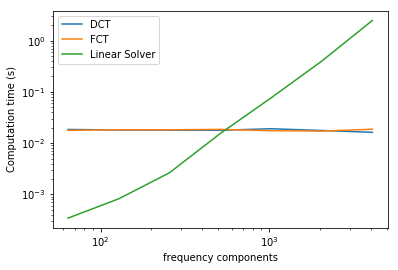

In [184]:
dcttimes = [res.best for res in dctresults]
ffttimes = [res.best for res in fftresults]
lintimes = [res.best for res in linresults]
plt.plot(ns,dcttimes)
plt.plot(ns,ffttimes)
plt.plot(ns,lintimes)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency components')
plt.ylabel('Computation time (s)')
plt.legend(['DCT','FCT','Linear Solver'])
plt.show()


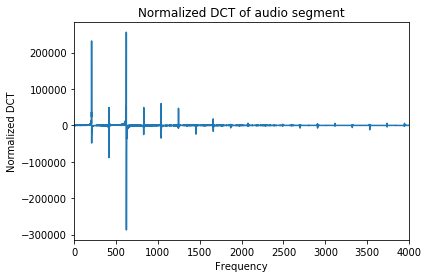

In [229]:
# Application of DCT (Compressing an Audio File)
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/SampleAudioFiles/'
fname = datafolder + '100475__iluppai__saxophone-weep.wav'
rate, data = scipy.io.wavfile.read(fname)
#sd.play(data,rate)
# split audio into segments and perform DCT
ts = np.arange(len(data)) * 1/rate
lts = np.all([ts >= 1.2,ts <= 1.7],axis=0)
ts_seg = ts[lts]
#sd.play(data[lts,0],rate)
res = scipy.fftpack.dct(data[lts,0],type=2,norm='ortho')
fs = (0.5 + np.arange(len(res))) / 2

maxDCTamplitude = np.max(res)
nres = res/maxDCTamplitude
plt.plot(fs,res)
plt.title('Normalized DCT of audio segment')
plt.ylabel('Normalized DCT')
plt.xlabel('Frequency')
plt.xlim([0,4000])
plt.show()

Eliminated  88.28624552174504 % of signal through compression


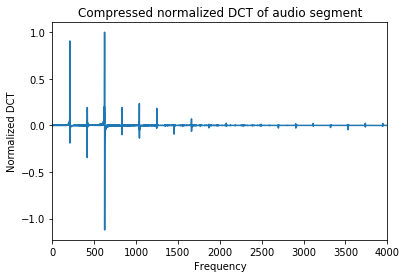

Now, we can just hold onto the relevant data: Amplitudes of most significant Frequencies
...reducing the amount of data that we store from  22051  to  2583


In [266]:
dctcompress,perf = compressAudioFile(nres.copy(),thresh = 0.001)
compressedDCT = dctcompress*maxDCTamplitude
print("Eliminated ",perf, "% of signal through compression")
plt.plot(fs,dctcompress)
plt.title('Compressed normalized DCT of audio segment')
plt.ylabel('Normalized DCT')
plt.xlabel('Frequency')
plt.xlim([0,4000])
plt.show()
lreconstructwave = abs(compressedDCT) > 0
N                = len(compressedDCT)
amplitudes       = compressedDCT[lreconstructwave]
frequencies      = fs[lreconstructwave]
print('Now, we can just hold onto the relevant data: Amplitudes of most significant Frequencies')
print('...reducing the amount of data that we store from ', N, ' to ', len(amplitudes))
# Use can then use the compressed data to recreate the audio wave
reconstructedDCT = np.zeros(N)
reconstructedDCT[lreconstructwave] = amplitudes
newaudio = scipy.fftpack.idct(reconstructedDCT,type=2,norm='ortho') / 2 / N
sd.play(newaudio,rate)